In [1]:
# Импорт библиотек.
import shutil
import re
import os
import pandas as pd
import tensorflow as tf
import nfp
from model_files.nfp_extensions import RBFExpansion, CifPreprocessor
import tensorflow_addons as tfa
from functions import get_structure
from pymatgen.core import Structure
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


2024-08-27 22:21:53.608469: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-27 22:21:53.683042: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-27 22:21:53.683145: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-27 22:21:53.683267: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-27 22:21:53.704346: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-27 22:21:53.705945: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
# Initialize the preprocessor class.
preprocessor = CifPreprocessor(num_neighbors=12)
preprocessor.from_json('./model_files/preprocessor.json')
# Load the model    
model = tf.keras.models.load_model(
    './model_files/best_model.hdf5',
    custom_objects={**nfp.custom_objects, **{'RBFExpansion': RBFExpansion}})

def get_data_set(spheres_list):
    max_sites = 196
    max_bonds = 10000
    test_dataset = tf.data.Dataset.from_generator(
        lambda: (preprocessor.construct_feature_matrices(fragment, train=False)
                for fragment in spheres_list),
        output_types=preprocessor.output_types,
        output_shapes=preprocessor.output_shapes)\
        .padded_batch(batch_size=32,
                    padded_shapes=preprocessor.padded_shapes(max_sites=max_sites, max_bonds=max_bonds),
                    padding_values=preprocessor.padding_values)
    
    return test_dataset

In [3]:
# Структуры из обучающего набора.
df_total = pd.read_csv('df_total.csv')
structure_names = pd.Series(os.listdir('structures')).str.replace('.vasp', '')
structure_names = df_total.loc[(df_total['structure_id'].isin(structure_names)), 'structure_id']

train_names = []
for name in structure_names:
    train_names.append(name)

FileNotFoundError: [Errno 2] No such file or directory: 'structures'

In [ ]:
df_total.loc[df_total['structure_id'].isin(structure_names), 'data_set'].value_counts()

data_set
train    2024
test      250
valid     216
Name: count, dtype: int64

In [ ]:
display(df_total.head())
df_to_plot = df_total.loc[df_total['structure_id'].isin(train_names)]

,AbsMax nm,smiles,element_composition,data_set,structure_id
0,345.0,B1C=Cc2c(ccc3ccccc23)N1,BCN,train,0_structure
1,357.0,B1C=Cc2cc3c(cc2N1)C=CBN3,BCN,train,1_structure
2,359.0,B1C=Cc2cc3ccccc3cc2N1,BCN,train,2_structure
3,352.0,B1C=Cc2ccc3ccccc3c2N1,BCN,train,3_structure
4,316.0,B1Nc2cccc3c2-n2c1ccc2BN3,BCN,train,4_structure


In [ ]:
compositions = df_to_plot['element_composition'].value_counts()[df_to_plot['element_composition'].value_counts() >=10].index
df_to_plot = df_to_plot.loc[df_to_plot['element_composition'].isin(compositions)]

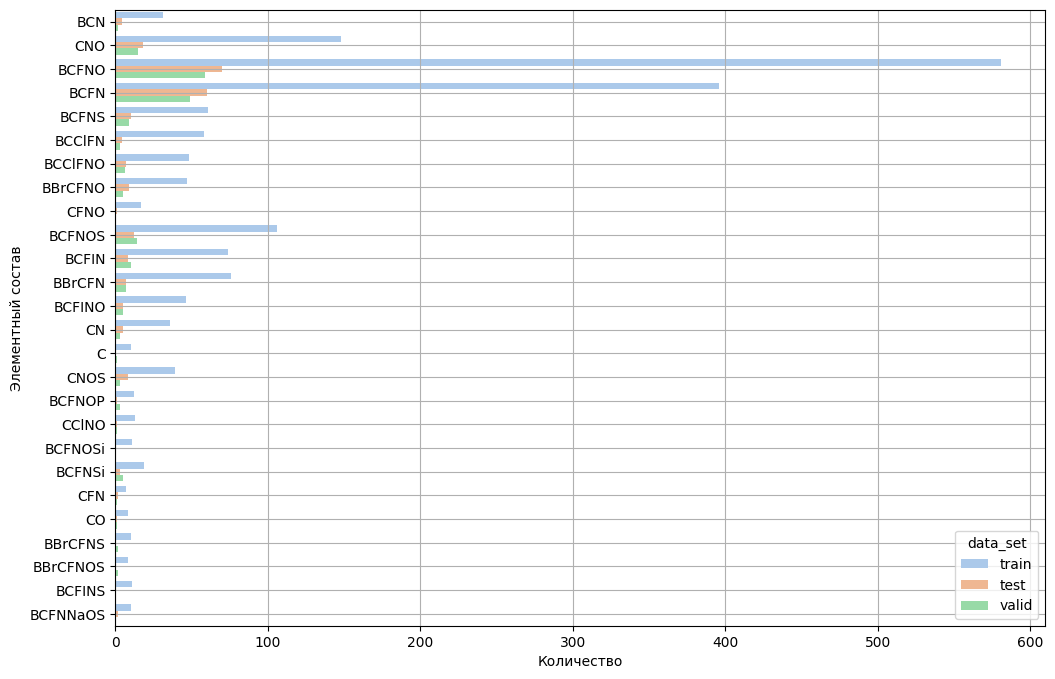

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(12, 8))
sns.countplot(
    data=df_to_plot, 
    y="element_composition", 
    hue="data_set",
    palette="pastel",
    ax=axs)
axs.grid()
# axs.set_title('Атомный состав')
axs.set_xlabel('Количество');
axs.set_ylabel('Элементный состав');

In [ ]:
# Структуры из тестового набора.
df_total = pd.read_csv('df_total.csv')
structure_names = pd.Series(os.listdir('structures')).str.replace('.vasp', '')
structure_names = df_total.loc[(df_total['structure_id'].isin(structure_names)) & 
                               (df_total['data_set'] == 'test')]

structures = []
DIR = 'structures/'
for name in structure_names['structure_id']:
    structures.append(Structure.from_file(DIR + name + '.vasp'))

data_to_predict = get_data_set(structures)    

In [ ]:
predictions = model.predict(data_to_predict)

2024-08-27 21:02:45.157931: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 327680000 exceeds 10% of free system memory.
2024-08-27 21:02:45.161889: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 327680000 exceeds 10% of free system memory.
2024-08-27 21:02:45.221968: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 327680000 exceeds 10% of free system memory.
2024-08-27 21:02:45.311446: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 327680000 exceeds 10% of free system memory.
2024-08-27 21:02:45.413370: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 164160000 exceeds 10% of free system memory.


8/8 [==============================] - 113s 14s/step


In [ ]:
results = df_total.loc[structure_names.index]
results['predictions'] = predictions

In [ ]:
true_values = results['AbsMax nm']
df = pd.DataFrame({
    'x': true_values.values.tolist(),
    'y': predictions.reshape(-1, )
})

y = np.array(predictions).reshape(-1,)
x = np.array(true_values)

df['delta'] = (0.5 * (df.x**2 + df.y**2 - 2*df.x*df.y)) ** (0.5)

In [ ]:
out = df[df['delta'] > 30]

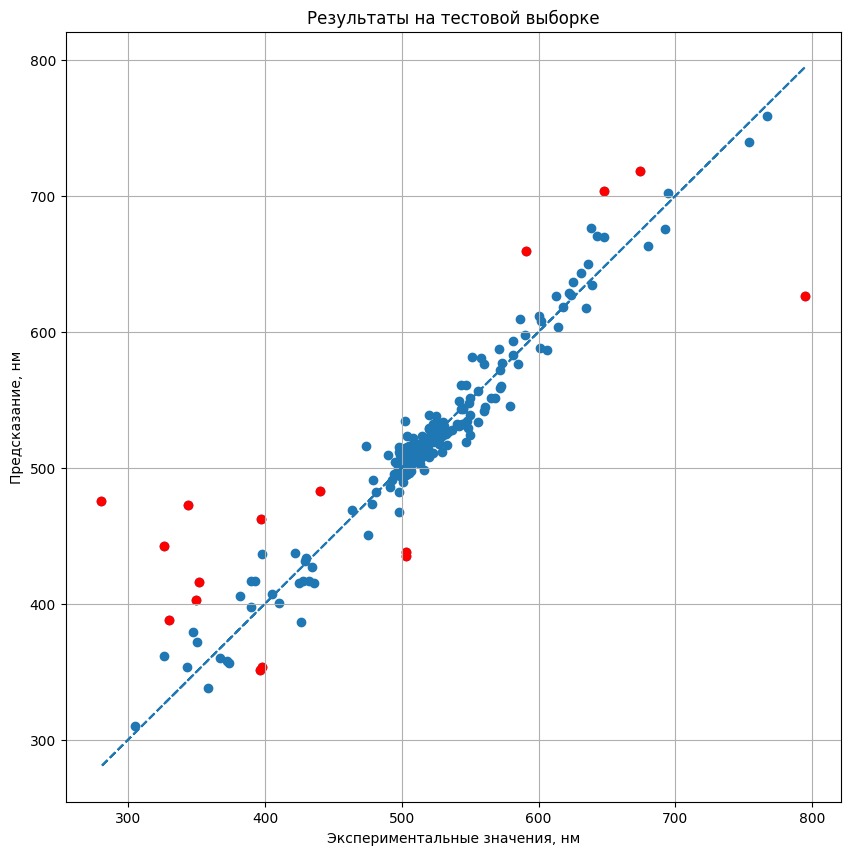

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
axs.scatter(true_values, predictions)
axs.scatter(out.x, out.y, color='red')
axs.plot(true_values, true_values, '--');
axs.grid();
axs.set_title('Результаты на тестовой выборке');
axs.set_xlabel('Экспериментальные значения, нм');
axs.set_ylabel('Предсказание, нм');
# for i,j,k in zip(out.x, out.y, out.index):
#     axs.annotate(k, (i+5, j+5), fontsize=14)

In [24]:
print(mean_absolute_error(results['AbsMax nm'], results['predictions']))
print(r2_score(results['AbsMax nm'], results['predictions']))

13.539265519243127
0.8705259884212564


In [25]:
# Структуры из тестового набора.
df_total = pd.read_csv('df_total.csv')
structure_names = pd.Series(os.listdir('structures')).str.replace('.vasp', '')
structure_names = df_total.loc[(df_total['structure_id'].isin(structure_names)) & 
                               (df_total['data_set'] == 'train')]

structures = []
DIR = 'structures/'
for name in structure_names['structure_id']:
    structures.append(Structure.from_file(DIR + name + '.vasp'))

data_to_predict = get_data_set(structures)    

predictions = model.predict(data_to_predict)
results = df_total.loc[structure_names.index]
results['predictions'] = predictions

true_values = results['AbsMax nm']
df = pd.DataFrame({
    'x': true_values.values.tolist(),
    'y': predictions.reshape(-1, )
})

y = np.array(predictions).reshape(-1,)
x = np.array(true_values)

df['delta'] = (0.5 * (df.x**2 + df.y**2 - 2*df.x*df.y)) ** (0.5)

out = df[df['delta'] > 30]

64/64 [==============================] - 1038s 16s/step


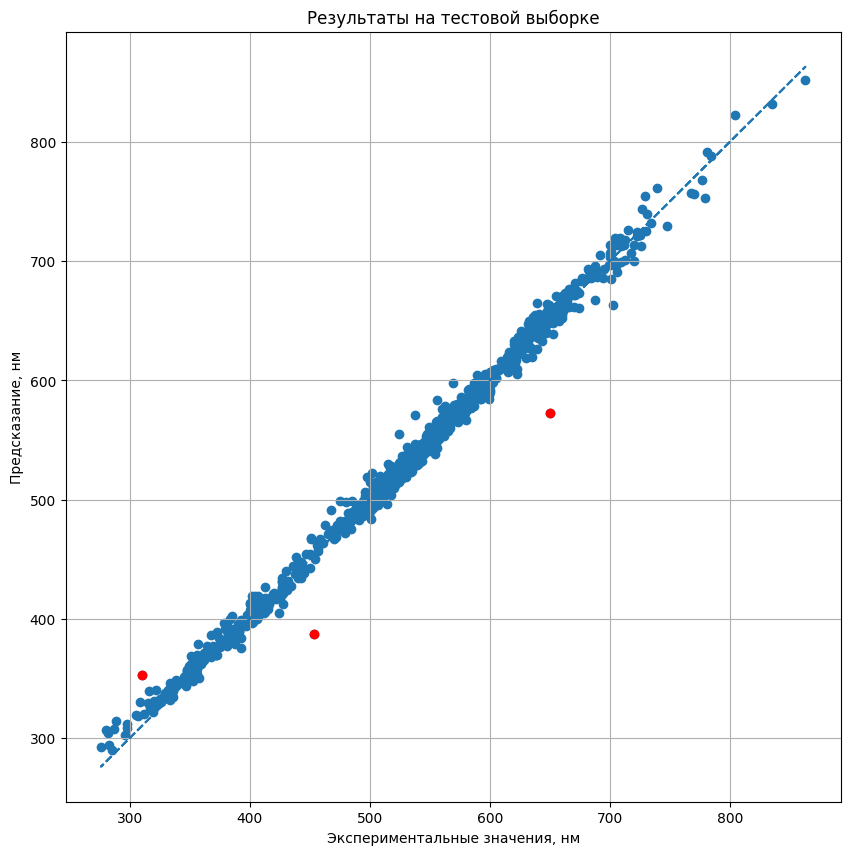

In [40]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
axs.scatter(true_values, predictions)
axs.scatter(out.x, out.y, color='red')
axs.plot(true_values, true_values, '--');
axs.grid();
axs.set_title('Результаты на тестовой выборке');
axs.set_xlabel('Экспериментальные значения, нм');
axs.set_ylabel('Предсказание, нм');
# for i,j,k in zip(out.x, out.y, out.index):
#     axs.annotate(k, (i+5, j+5), fontsize=14)

In [27]:
print(mean_absolute_error(results['AbsMax nm'], results['predictions']))
print(r2_score(results['AbsMax nm'], results['predictions']))

4.322249275832799
0.9927610319069137


In [42]:
df.to_csv('result_on_train.csv', index=False)